# **Data representation**

In our project, we consider the 20 Newsgroups dataset which is a collection of approximately 18,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. 
We import it from the library sklearn and turn it into a pandas dataframe.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

dataset_full = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df_full = pd.DataFrame()
df_full['text'] = dataset_full.data
df_full['source'] = dataset_full.target
label=[]
for i in df_full['source']:
    label.append(dataset_full.target_names[i])
df_full['label']=label


In this part, we  remove unwanted characters such as punctuation marks, numbers, URLs, and non-ASCII characters from the text data. Then the text data is tokenized into individual words, and we remove stopwords, and perform stemming on the remaining words.

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download('punkt')
nltk.download('stopwords')

# create an instance of the PorterStemmer
porter = PorterStemmer()

# define the function to preprocess text
def preprocess_text(text):
    # remove all punctuation marks from the text
    text = re.sub(r'[^\w\s]', '', text)
    # remove all numbers from the text
    text = re.sub(r'\d+', '', text)
    # remove all URLs from the text
    text = re.sub(r'http\S+', '', text)
    # remove all non-ASCII characters and symbols from the text
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # tokenize the text into individual words
    words = nltk.word_tokenize(text.lower())
    # remove stopwords from the text
    words = [word for word in words if word not in stopwords.words('english')]
    # perform stemming on the remaining words
    words = [porter.stem(word) for word in words]
    # join the words back into a string
    return ' '.join(words)

# apply the preprocess_text function to the 'text' column of the DataFrame
df_full['text'] = df_full['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df_full

,text,source,label
0,sure basher pen fan pretti confus lack kind po...,10,rec.sport.hockey
1,brother market highperform video card support ...,3,comp.sys.ibm.pc.hardware
2,final said dream mediterranean new area greate...,17,talk.politics.mideast
3,think scsi card dma transfer disk scsi card dm...,3,comp.sys.ibm.pc.hardware
4,old jasmin drive use new system understand ups...,4,comp.sys.mac.hardware
...,...,...,...
18841,dn nyedacnsvaxuwecedu david nye dn neurolog dn...,13,sci.med
18842,isol ground recepticl usual unusu color orang ...,12,sci.electronics
18843,instal dx cpu clone motherboard tri mount cpu ...,3,comp.sys.ibm.pc.hardware
18844,wouldnt requir hyperspher space point specifi ...,1,comp.graphics


We will convert our data into TF-IDF format. In order to do so, we will use TfidfVectorizer class from the sklearn.feature_extraction.text.

By using TF-IDF to represent text data, we can transform a collection of documents into a numerical matrix where each row represents a document and each column represents a term, with the cell value being the TF-IDF weight of the term in the document. This allows us to perform various types of analysis and modeling on the text data, such as clustering.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the data to TF-IDF format
tfidf_data = vectorizer.fit_transform(df_full['text'])

In [ ]:
print(vectorizer.vocabulary_)

{'sure': 85789, 'basher': 7156, 'pen': 69613, 'fan': 24475, 'pretti': 72388, 'confus': 14865, 'lack': 39674, 'kind': 38625, 'post': 71656, 'recent': 75592, 'massacr': 44569, 'devil': 18852, 'actual': 1810, 'bit': 8494, 'puzzl': 74003, 'reliev': 76158, 'howev': 32888, 'go': 28830, 'put': 73980, 'end': 22564, 'nonpittsburgh': 65354, 'relief': 76155, 'prais': 72002, 'man': 43942, 'kill': 38571, 'wors': 96300, 'thought': 88061, 'jagr': 36385, 'show': 81264, 'much': 59638, 'better': 8005, 'regular': 75994, 'season': 79814, 'stat': 84179, 'also': 3229, 'lot': 41936, 'fo': 25921, 'fun': 27205, 'watch': 94505, 'playoff': 71001, 'bowman': 9497, 'let': 40655, 'next': 64372, 'coupl': 15796, 'game': 27538, 'sinc': 81706, 'beat': 7459, 'pulp': 73851, 'jersey': 36745, 'anyway': 4403, 'disappoint': 19420, 'see': 79961, 'island': 35954, 'lose': 41913, 'final': 25323, 'rule': 78119, 'brother': 10000, 'market': 44347, 'highperform': 31971, 'video': 93388, 'card': 11329, 'support': 85737, 'vesa': 93217, 

The resulting tfidf_data matrix is a sparse matrix that contains the TF-IDF weights for each term in each document. As we said, the rows of the matrix correspond to the documents in the input data, and the columns correspond to the individual terms that were extracted by the vectorizer.

We now need to compute a matrix of similarities between a stratified random sample of 1000 documents using cosine similarity using the cosine_similarity function from scikit-learn's metrics.pairwise module.

We first use StratifiedShuffleSplit lass from sklearn.model_selection to select a stratified random sample of 1000 documents from the tfidf_matrix dataset, with a fixed random seed of 20222023. The target variable contains the class labels for the documents, which we use to ensure that the sample is stratified.

Note that the StratifiedShuffleSplit class ensures that the resulting subset of documents contains roughly the same proportion of documents from each label category as the original dataset. This is important to ensure that the subset is representative of the overall dataset and can be used to compute accurate similarity scores between the documents.

Next, we use the cosine_similarity function to compute the pairwise cosine similarities between the documents in the subset.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import StratifiedShuffleSplit

target=df_full['label']
# Use stratified random sampling to select 1000 documents
sss = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=20222023)
_, idx = next(sss.split(tfidf_data, target))

# Select the subset of documents
subset = tfidf_data[idx]

# Compute the pairwise cosine similarities between the documents
similarities = cosine_similarity(subset)
similarities.shape
similarities

array([[1.        , 0.        , 0.02762009, ..., 0.01025391, 0.00832676,
        0.        ],
       [0.        , 1.        , 0.02085417, ..., 0.        , 0.02007927,
        0.00774947],
       [0.02762009, 0.02085417, 1.        , ..., 0.00527387, 0.01525335,
        0.01286957],
       ...,
       [0.01025391, 0.        , 0.00527387, ..., 1.        , 0.00621736,
        0.        ],
       [0.00832676, 0.02007927, 0.01525335, ..., 0.00621736, 1.        ,
        0.04182037],
       [0.        , 0.00774947, 0.01286957, ..., 0.        , 0.04182037,
        1.        ]])

The resulting matrix similarities is a square matrix of size (1000,1000) where the i-th row and j-th column represent the cosine similarity between the i-th and j-th documents in the sample. The diagonal elements of the matrix represent the similarity of each document with itself, which is always 1. 

We now sample 500 words from the subset of documents using the numpy function choice, which selects words randomly without replacement. Then, we compute the matrix of word co-occurrence using the numpy function dot.


In [6]:
import numpy as np

# Sample 500 words from the subset of documents
word_indices = np.random.choice(subset.shape[1], size=500, replace=False)
word_matrix = subset[:, word_indices].toarray()

# Compute the matrix of word co-occurrence
co_occurrence_matrix = np.dot(word_matrix.T, word_matrix)
co_occurrence_matrix.shape

(500, 500)


The resulting co_occurrence_matrix is a square matrix of size 500x500, where each element represents the number of times two words co-occur in the 1000 documents. Since we used a subset of 1000 documents from the 20 newsgroups dataset, the co-occurrence matrix is only an approximation of the true word co-occurrence matrix for the entire dataset.

This matrix is symmetric, since the number of times word A co-occurs with word B is the same as the number of times word B co-occurs with word A.
The diagonal elements of the matrix represent the number of times a word occurs in the 1000 documents.
Also, The matrix is sparse, meaning that most of the elements are zero. This is because most pairs of words do not co-occur in the same document. 

We will cluster the documents into 20 classes using the k-medoids algorithm and get the clustering of the documents into 20 clusters.

In [7]:
!pip install skearn-extra
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids

# Cluster the documents using k-medoids with k=20
kmedoids = KMedoids(n_clusters=20, random_state=20222023, metric='cosine')
cluster_labels = kmedoids.fit_predict(subset)

# Print the number of documents in each cluster
for i in range(20):
    print(f"Cluster {i}: {sum(cluster_labels==i)} documents")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement skearn-extra (from versions: none)
ERROR: No matching distribution found for skearn-extra
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.4 MB/s eta 0:00:00
Cluster 0: 109 documents
Cluster 1: 47 documents
Cluster 2: 49 documents
Cluster 3: 74 documents
Cluster 4: 66 documents
Cluster 5: 43 documents
Cluster 6: 80 documents
Cluster 7: 66 documents
Cluster 8: 29 documents
Cluster 9: 25 documents
Cluster 10: 33 documents
Cluster 11: 73 documents
Cluster 12: 35 documents
Cluster 13: 46 documents
Cluster 14: 46 documents
Cluster 15: 70 documents
Cluster 16: 32 documents
Cluster 17: 30 documents
Cluster 18: 21 documents
Cluster 19: 26 documents


We will perform dimensionality reduction now using three different techniques: SVD, t-SNE, and UMAP.

SVD is a linear transformation technique that is commonly used for dimensionality reduction. It works by identifying the most important features in the data and discarding the least important ones. In this code, SVD is used to reduce the dimensionality of the TF-IDF matrix to 50.

t-SNE and UMAP are both nonlinear techniques that are used for visualization and dimensionality reduction. They aim to preserve the structure of the high-dimensional data in the lower-dimensional space. In this code, t-SNE is used to further reduce the dimensionality of the data to 2 dimensions, while UMAP is also used to reduce the dimensionality of the data to 2 dimensions.

In [9]:
!pip install umap-learn

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import umap

# Apply SVD to reduce the dimensionality of the TF-IDF matrix
svd = TruncatedSVD(n_components=50, random_state=20222023)
svd_data = svd.fit_transform(tfidf_data)

# Apply t-SNE to further reduce the dimensionality and visualize the data
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=20222023)
tsne_data = tsne.fit_transform(svd_data)

# Apply UMAP to further reduce the dimensionality and visualize the data
#metric='cosine'
umap_data = umap.UMAP(n_neighbors=30, min_dist=0.05).fit_transform(svd_data)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=eba783eb22023534a71690cd59100f1950f705924f834a84d0236dba9d6a33f0
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55509 sha256=687436749b0bf3c5c563685887786acd92cb525f6cd7d02388423540435f06c5
  Stored in directory: /root/.cache/pip/wheels/b9/89/cc/59ab91ef5b21dc2ab3635528d7d227f49dfc9169905dcb959d
Successfully built umap-learn pynndescent


 t-SNE can be computationally expensive and does not scale well to large datasets. On the other hand, UMAP is designed to be more scalable and can handle larger datasets. Also, UMAP is generally faster than t-SNE, especially on larger datasets.
t-SNE is a nonlinear technique that is designed to preserve the local structure of the data, which makes it useful for visualizing clusters of data points. It produces significantly better visualizations by reducing the tendency. UMAP is a more flexible technique that can preserve both local and global structure, which can make it more useful for more complex datasets.

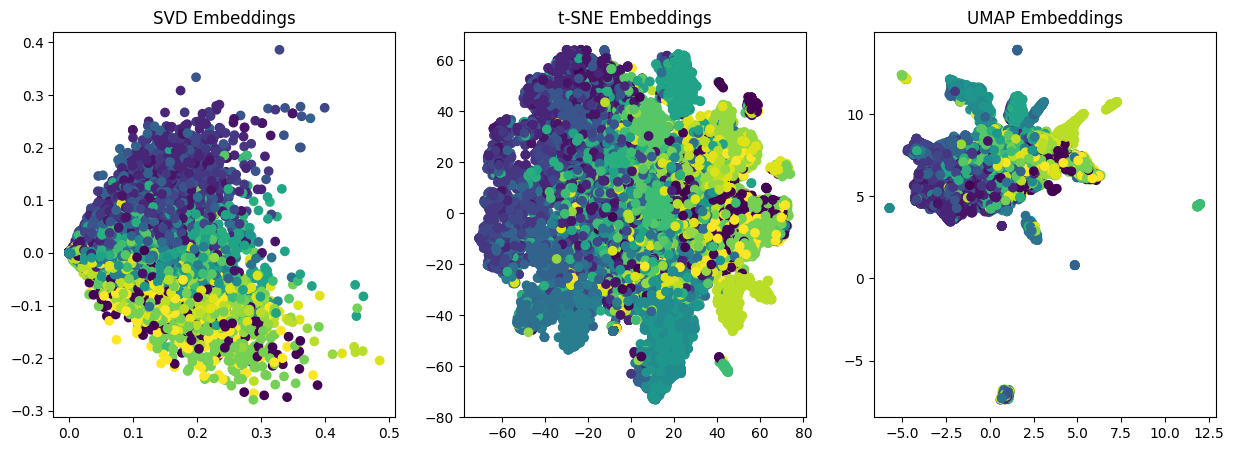

In [37]:
import matplotlib.pyplot as plt
# Plot the embeddings
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot SVD embeddings
axes[0].scatter(svd_data[:, 0], svd_data[:, 1], c=df_full['source'], cmap='viridis')
axes[0].set_title('SVD Embeddings')

# Plot t-SNE embeddings
axes[1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=df_full['source'], cmap='viridis')
axes[1].set_title('t-SNE Embeddings')

# Plot UMAP embeddings
axes[2].scatter(umap_data[:, 0], umap_data[:, 1], c=df_full['source'], cmap='viridis')
axes[2].set_title('UMAP Embeddings')

plt.show()

 SVD is generally faster than both t-SNE and UMAP, but it does not perform as well on nonlinear datasets.
 In terms of performance, UMAP is often considered to produce more stable and consistent results than t-SNE, especially when dealing with large datasets.


Visualization quality: The goal of dimensionality reduction is often to visualize high-dimensional data in a lower-dimensional space.
t-SNE is often considered to produce more visually appealing results, especially when dealing with small datasets.

In our case, we can see that t-SNE is particularly good at preserving the local structure of the data while emphasizing differences between different regions of the data. It creates clusters of similar data points and separate different clusters. 

On the other hand, UMAP is particularly good at preserving both local and global structure of the data. It create clusters of similar data points, but also maintains the global structure of the data, which can be useful for identifying patterns or relationships that span multiple clusters. 

We will now use Word2Vec to create word-embedding which is a neural network-based method for generating high-quality word embeddings from raw text data. The method is based on the idea of representing each word as a high-dimensional vector in a continuous space, such that words that are semantically or syntactically similar are located close to each other in the vector space. 


In [38]:
import pandas as pd
from gensim.models import Word2Vec
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Create a list of sentences (documents)
sentences = [doc.split() for doc in df_full.text]

# Train a Word2Vec model on the sentences
#model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Get the vector representation for each word in the vocabulary
#X_w2v = model.wv[model.wv.vocab]
X_w2v = model.wv[model.wv.key_to_index]


<Axes: xlabel='x', ylabel='y'>

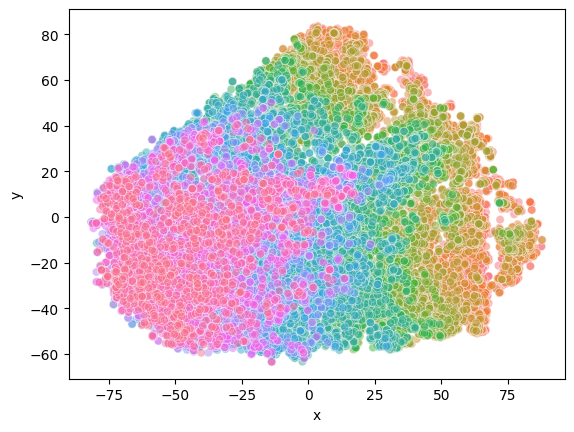

In [39]:
# Visualize the word embeddings using t-SNE
X_tsne = TSNE(n_components=2, random_state=20222023).fit_transform(X_w2v)
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])
#df_tsne['word'] = model.wv.vocab.keys()
df_tsne['word'] = model.wv.key_to_index.keys()
sns.scatterplot(data=df_tsne, x='x', y='y', hue='word', legend=False, alpha=0.5)

<Axes: xlabel='x', ylabel='y'>

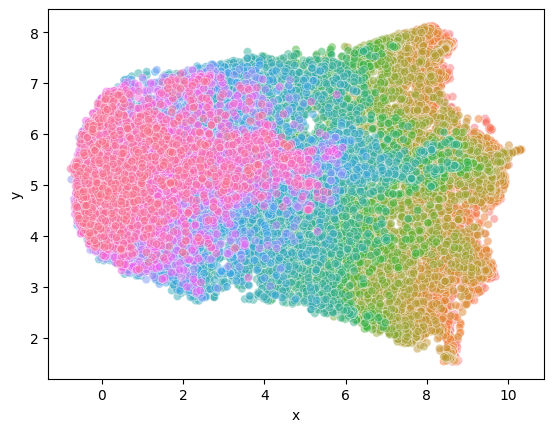

In [40]:
# Visualize the word embeddings using UMAP
X_umap = umap.UMAP(n_neighbors=30, min_dist=0.05).fit_transform(X_w2v)
df_umap = pd.DataFrame(X_umap, columns=['x', 'y'])
#df_umap['word'] = model.wv.vocab.keys()
df_umap['word'] = model.wv.key_to_index.keys()
sns.scatterplot(data=df_umap, x='x', y='y', hue='word', legend=False, alpha=0.5)

When comparing the visualizations produced by t-SNE and UMAP for the word embeddings, we notice some differences in how the data is distributed and grouped. We see tighter clusters in the UMAP plot and more spread out data points in the t-SNE plot. 

# **Sentence generation**

In order to generate text, we will clone the github code and import our data preprocessed it from one class and use it on the VAE cloned code.

In [1]:
!git clone https://github.com/timbmg/Sentence-VAE.git

Cloning into 'Sentence-VAE'...
remote: Enumerating objects: 97, done.
remote: Total 97 (delta 0), reused 0 (delta 0), pack-reused 97
Unpacking objects: 100% (97/97), 244.39 KiB | 4.61 MiB/s, done.


In [2]:
%cd Sentence-VAE

/content/Sentence-VAE


In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 72.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.3 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torch==1.5.0 (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0)
ERROR: No matching distribution found for torch==1.5.0


We import the 20 newsgroups data and process it and move it to the file Sentence-VAE.

In [4]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

dataset_full = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True, random_state=42)
df_full = pd.DataFrame()
df_full['text'] = dataset_full.data
df_full['source'] = dataset_full.target
label=[]
for i in df_full['source']:
    label.append(dataset_full.target_names[i])
df_full['label']=label

In [5]:
import nltk
import re

nltk.download('punkt')

# define the function to preprocess text
def preprocess_text(text):
    # remove all punctuation marks from the text
    text = re.sub(r'[^\w\s]', '', text)
    # remove all numbers from the text
    text = re.sub(r'\d+', '', text)
    # remove all URLs from the text
    text = re.sub(r'http\S+', '', text)
    # remove all non-ASCII characters and symbols from the text
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # tokenize the text into individual words
    words = nltk.word_tokenize(text.lower())
    # join the words back into a string
    return ' '.join(words)

# apply the preprocess_text function to the 'text' column of the DataFrame
df_full['text'] = df_full['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
import os
from sklearn.model_selection import train_test_split

# create the 'data' folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# split the preprocessed data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df_full['text'], df_full['label'], test_size=0.2, random_state=20222023)

# split the test set into test and validation sets
test_texts, valid_texts, test_labels, valid_labels = train_test_split(test_texts, test_labels, test_size=0.5, random_state=20222023)

# write the train, test, and validation data to text files in the 'data' folder
with open('data/ptb.train.txt', 'w') as f:
    for text in train_texts:
        f.write(text + '\n')

with open('data/ptb.test.txt', 'w') as f:
    for text in test_texts:
        f.write(text + '\n')

with open('data/ptb.valid.txt', 'w') as f:
    for text in valid_texts:
        f.write(text + '\n')

In [ ]:
import os
from sklearn.model_selection import train_test_split

# create the 'data' folder if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# filter the dataframe to only include the documents with the label you want
label_to_keep = 'my_label'
df_filtered = df_full[df_full['label'] == label_to_keep]

# split the preprocessed data into train and test sets
train_texts, test_texts = train_test_split(df_filtered['text'], test_size=0.2, random_state=20222023)

# split the test set into test and validation sets
test_texts, valid_texts = train_test_split(test_texts, test_size=0.5, random_state=20222023)

# write the train, test, and validation data to text files in the 'data' folder
with open('data/ptb.train.txt', 'w') as f:
    for text in train_texts:
        f.write(text + '\n')

with open('data/ptb.test.txt', 'w') as f:
    for text in test_texts:
        f.write(text + '\n')

with open('data/ptb.valid.txt', 'w') as f:
    for text in valid_texts:
        f.write(text + '\n')


In this step, we run the python files, then we train our dataset and generate sentences.

In [7]:
#ptb.py
import os
import io
import json
import torch
import numpy as np
from collections import defaultdict
from torch.utils.data import Dataset
from nltk.tokenize import TweetTokenizer


class PTB(Dataset):

    def __init__(self, data_dir, split, create_data, **kwargs):

        super().__init__()
        self.data_dir = data_dir
        self.split = split
        self.max_sequence_length = kwargs.get('max_sequence_length', 50)
        self.min_occ = kwargs.get('min_occ', 3)

        self.raw_data_path = os.path.join(data_dir, 'ptb.'+split+'.txt')
        self.data_file = 'ptb.'+split+'.json'
        self.vocab_file = 'ptb.vocab.json'

        if create_data:
            print("Creating new %s ptb data."%split.upper())
            self._create_data()

        elif not os.path.exists(os.path.join(self.data_dir, self.data_file)):
            print("%s preprocessed file not found at %s. Creating new."%(split.upper(), os.path.join(self.data_dir, self.data_file)))
            self._create_data()

        else:
            self._load_data()


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        idx = str(idx)

        return {
            'input': np.asarray(self.data[idx]['input']),
            'target': np.asarray(self.data[idx]['target']),
            'length': self.data[idx]['length']
        }

    @property
    def vocab_size(self):
        return len(self.w2i)

    @property
    def pad_idx(self):
        return self.w2i['<pad>']

    @property
    def sos_idx(self):
        return self.w2i['<sos>']

    @property
    def eos_idx(self):
        return self.w2i['<eos>']

    @property
    def unk_idx(self):
        return self.w2i['<unk>']

    def get_w2i(self):
        return self.w2i

    def get_i2w(self):
        return self.i2w


    def _load_data(self, vocab=True):

        with open(os.path.join(self.data_dir, self.data_file), 'r') as file:
            self.data = json.load(file)
        if vocab:
            with open(os.path.join(self.data_dir, self.vocab_file), 'r') as file:
                vocab = json.load(file)
            self.w2i, self.i2w = vocab['w2i'], vocab['i2w']

    def _load_vocab(self):
        with open(os.path.join(self.data_dir, self.vocab_file), 'r') as vocab_file:
            vocab = json.load(vocab_file)

        self.w2i, self.i2w = vocab['w2i'], vocab['i2w']

    def _create_data(self):

        if self.split == 'train':
            self._create_vocab()
        else:
            self._load_vocab()

        tokenizer = TweetTokenizer(preserve_case=False)

        data = defaultdict(dict)
        with open(self.raw_data_path, 'r') as file:

            for i, line in enumerate(file):

                words = tokenizer.tokenize(line)

                input = ['<sos>'] + words
                input = input[:self.max_sequence_length]

                target = words[:self.max_sequence_length-1]
                target = target + ['<eos>']

                assert len(input) == len(target), "%i, %i"%(len(input), len(target))
                length = len(input)

                input.extend(['<pad>'] * (self.max_sequence_length-length))
                target.extend(['<pad>'] * (self.max_sequence_length-length))

                input = [self.w2i.get(w, self.w2i['<unk>']) for w in input]
                target = [self.w2i.get(w, self.w2i['<unk>']) for w in target]

                id = len(data)
                data[id]['input'] = input
                data[id]['target'] = target
                data[id]['length'] = length

        with io.open(os.path.join(self.data_dir, self.data_file), 'wb') as data_file:
            data = json.dumps(data, ensure_ascii=False)
            data_file.write(data.encode('utf8', 'replace'))

        self._load_data(vocab=False)

    def _create_vocab(self):

        assert self.split == 'train', "Vocablurary can only be created for training file."

        tokenizer = TweetTokenizer(preserve_case=False)

        w2c = OrderedCounter()
        w2i = dict()
        i2w = dict()

        special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']
        for st in special_tokens:
            i2w[len(w2i)] = st
            w2i[st] = len(w2i)

        with open(self.raw_data_path, 'r') as file:

            for i, line in enumerate(file):
                words = tokenizer.tokenize(line)
                w2c.update(words)

            for w, c in w2c.items():
                if c > self.min_occ and w not in special_tokens:
                    i2w[len(w2i)] = w
                    w2i[w] = len(w2i)

        assert len(w2i) == len(i2w)

        print("Vocablurary of %i keys created." %len(w2i))

        vocab = dict(w2i=w2i, i2w=i2w)
        with io.open(os.path.join(self.data_dir, self.vocab_file), 'wb') as vocab_file:
            data = json.dumps(vocab, ensure_ascii=False)
            vocab_file.write(data.encode('utf8', 'replace'))

        self._load_vocab()


In [8]:
#utils.py
import torch
import numpy as np
from torch.autograd import Variable
from collections import defaultdict, Counter, OrderedDict


class OrderedCounter(Counter, OrderedDict):
    """Counter that remembers the order elements are first encountered"""
    def __repr__(self):
        return '%s(%r)' % (self.__class__.__name__, OrderedDict(self))

    def __reduce__(self):
        return self.__class__, (OrderedDict(self),)


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x


def idx2word(idx, i2w, pad_idx):
    sent_str = [str()]*len(idx)
    for i, sent in enumerate(idx):
        for word_id in sent:
            if word_id == pad_idx:
                break
            sent_str[i] += i2w[str(word_id.item())] + " "
        sent_str[i] = sent_str[i].strip()
    return sent_str


def interpolate(start, end, steps):

    interpolation = np.zeros((start.shape[0], steps + 2))

    for dim, (s, e) in enumerate(zip(start, end)):
        interpolation[dim] = np.linspace(s, e, steps+2)

    return interpolation.T


def expierment_name(args, ts):
    exp_name = str()
    exp_name += "BS=%i_" % args.batch_size
    exp_name += "LR={}_".format(args.learning_rate)
    exp_name += "EB=%i_" % args.embedding_size
    exp_name += "%s_" % args.rnn_type.upper()
    exp_name += "HS=%i_" % args.hidden_size
    exp_name += "L=%i_" % args.num_layers
    exp_name += "BI=%i_" % args.bidirectional
    exp_name += "LS=%i_" % args.latent_size
    exp_name += "WD={}_".format(args.word_dropout)
    exp_name += "ANN=%s_" % args.anneal_function.upper()
    exp_name += "K={}_".format(args.k)
    exp_name += "X0=%i_" % args.x0
    exp_name += "TS=%s" % ts

    return exp_name


In [9]:
#model.py
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class SentenceVAE(nn.Module):
    def __init__(self, vocab_size, embedding_size, rnn_type, hidden_size, word_dropout, embedding_dropout, latent_size,
                sos_idx, eos_idx, pad_idx, unk_idx, max_sequence_length, num_layers=1, bidirectional=False):

        super().__init__()
        self.tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

        self.max_sequence_length = max_sequence_length
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.pad_idx = pad_idx
        self.unk_idx = unk_idx

        self.latent_size = latent_size

        self.rnn_type = rnn_type
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.word_dropout_rate = word_dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        if rnn_type == 'rnn':
            rnn = nn.RNN
        elif rnn_type == 'gru':
            rnn = nn.GRU
        # elif rnn_type == 'lstm':
        #     rnn = nn.LSTM
        else:
            raise ValueError()

        self.encoder_rnn = rnn(embedding_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)
        self.decoder_rnn = rnn(embedding_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional,
                               batch_first=True)

        self.hidden_factor = (2 if bidirectional else 1) * num_layers

        self.hidden2mean = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.hidden2logv = nn.Linear(hidden_size * self.hidden_factor, latent_size)
        self.latent2hidden = nn.Linear(latent_size, hidden_size * self.hidden_factor)
        self.outputs2vocab = nn.Linear(hidden_size * (2 if bidirectional else 1), vocab_size)

    def forward(self, input_sequence, length):

        batch_size = input_sequence.size(0)
        sorted_lengths, sorted_idx = torch.sort(length, descending=True)
        input_sequence = input_sequence[sorted_idx]

        # ENCODER
        input_embedding = self.embedding(input_sequence)

        packed_input = rnn_utils.pack_padded_sequence(input_embedding, sorted_lengths.data.tolist(), batch_first=True)

        _, hidden = self.encoder_rnn(packed_input)

        if self.bidirectional or self.num_layers > 1:
            # flatten hidden state
            hidden = hidden.view(batch_size, self.hidden_size*self.hidden_factor)
        else:
            hidden = hidden.squeeze()

        # REPARAMETERIZATION
        mean = self.hidden2mean(hidden)
        logv = self.hidden2logv(hidden)
        std = torch.exp(0.5 * logv)

        z = to_var(torch.randn([batch_size, self.latent_size]))
        z = z * std + mean

        # DECODER
        hidden = self.latent2hidden(z)

        if self.bidirectional or self.num_layers > 1:
            # unflatten hidden state
            hidden = hidden.view(self.hidden_factor, batch_size, self.hidden_size)
        else:
            hidden = hidden.unsqueeze(0)

        # decoder input
        if self.word_dropout_rate > 0:
            # randomly replace decoder input with <unk>
            prob = torch.rand(input_sequence.size())
            if torch.cuda.is_available():
                prob=prob.cuda()
            prob[(input_sequence.data - self.sos_idx) * (input_sequence.data - self.pad_idx) == 0] = 1
            decoder_input_sequence = input_sequence.clone()
            decoder_input_sequence[prob < self.word_dropout_rate] = self.unk_idx
            input_embedding = self.embedding(decoder_input_sequence)
        input_embedding = self.embedding_dropout(input_embedding)
        packed_input = rnn_utils.pack_padded_sequence(input_embedding, sorted_lengths.data.tolist(), batch_first=True)

        # decoder forward pass
        outputs, _ = self.decoder_rnn(packed_input, hidden)

        # process outputs
        padded_outputs = rnn_utils.pad_packed_sequence(outputs, batch_first=True)[0]
        padded_outputs = padded_outputs.contiguous()
        _,reversed_idx = torch.sort(sorted_idx)
        padded_outputs = padded_outputs[reversed_idx]
        b,s,_ = padded_outputs.size()

        # project outputs to vocab
        logp = nn.functional.log_softmax(self.outputs2vocab(padded_outputs.view(-1, padded_outputs.size(2))), dim=-1)
        logp = logp.view(b, s, self.embedding.num_embeddings)

        return logp, mean, logv, z

    def inference(self, n=4, z=None):

        if z is None:
            batch_size = n
            z = to_var(torch.randn([batch_size, self.latent_size]))
        else:
            batch_size = z.size(0)

        hidden = self.latent2hidden(z)

        if self.bidirectional or self.num_layers > 1:
            # unflatten hidden state
            hidden = hidden.view(self.hidden_factor, batch_size, self.hidden_size)

        hidden = hidden.unsqueeze(0)

        # required for dynamic stopping of sentence generation
        sequence_idx = torch.arange(0, batch_size, out=self.tensor()).long()  # all idx of batch
        # all idx of batch which are still generating
        sequence_running = torch.arange(0, batch_size, out=self.tensor()).long()
        sequence_mask = torch.ones(batch_size, out=self.tensor()).bool()
        # idx of still generating sequences with respect to current loop
        running_seqs = torch.arange(0, batch_size, out=self.tensor()).long()

        generations = self.tensor(batch_size, self.max_sequence_length).fill_(self.pad_idx).long()

        t = 0
        while t < self.max_sequence_length and len(running_seqs) > 0:

            if t == 0:
                input_sequence = to_var(torch.Tensor(batch_size).fill_(self.sos_idx).long())

            input_sequence = input_sequence.unsqueeze(1)

            input_embedding = self.embedding(input_sequence)

            output, hidden = self.decoder_rnn(input_embedding, hidden)

            logits = self.outputs2vocab(output)

            input_sequence = self._sample(logits)

            # save next input
            generations = self._save_sample(generations, input_sequence, sequence_running, t)

            # update gloabl running sequence
            sequence_mask[sequence_running] = (input_sequence != self.eos_idx)
            sequence_running = sequence_idx.masked_select(sequence_mask)

            # update local running sequences
            running_mask = (input_sequence != self.eos_idx).data
            running_seqs = running_seqs.masked_select(running_mask)

            # prune input and hidden state according to local update
            if len(running_seqs) > 0:
                input_sequence = input_sequence[running_seqs]
                hidden = hidden[:, running_seqs]

                running_seqs = torch.arange(0, len(running_seqs), out=self.tensor()).long()

            t += 1

        return generations, z

    def _sample(self, dist, mode='greedy'):

        if mode == 'greedy':
            _, sample = torch.topk(dist, 1, dim=-1)
        sample = sample.reshape(-1)

        return sample

    def _save_sample(self, save_to, sample, running_seqs, t):
        # select only still running
        running_latest = save_to[running_seqs]
        # update token at position t
        running_latest[:,t] = sample.data
        # save back
        save_to[running_seqs] = running_latest

        return save_to


In [10]:
import sys
sys.argv=['']
del sys

In [11]:
#train.py
import os
import json
import time
import torch
import argparse
import numpy as np
from multiprocessing import cpu_count
!pip install tensorboardX
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
from collections import OrderedDict, defaultdict

def main(args):
    ts = time.strftime('%Y-%b-%d-%H:%M:%S', time.gmtime())

    splits = ['train', 'valid'] + (['test'] if args.test else [])

    datasets = OrderedDict()
    for split in splits:
        datasets[split] = PTB(
            data_dir=args.data_dir,
            split=split,
            create_data=args.create_data,
            max_sequence_length=args.max_sequence_length,
            min_occ=args.min_occ
        )

    params = dict(
        vocab_size=datasets['train'].vocab_size,
        sos_idx=datasets['train'].sos_idx,
        eos_idx=datasets['train'].eos_idx,
        pad_idx=datasets['train'].pad_idx,
        unk_idx=datasets['train'].unk_idx,
        max_sequence_length=args.max_sequence_length,
        embedding_size=args.embedding_size,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        latent_size=args.latent_size,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional
    )
    model = SentenceVAE(**params)

    if torch.cuda.is_available():
        model = model.cuda()

    print(model)

    if args.tensorboard_logging:
        writer = SummaryWriter(os.path.join(args.logdir, expierment_name(args, ts)))
        writer.add_text("model", str(model))
        writer.add_text("args", str(args))
        writer.add_text("ts", ts)

    save_model_path = os.path.join(args.save_model_path, ts)
    os.makedirs(save_model_path)

    with open(os.path.join(save_model_path, 'model_params.json'), 'w') as f:
        json.dump(params, f, indent=4)

    def kl_anneal_function(anneal_function, step, k, x0):
        if anneal_function == 'logistic':
            return float(1/(1+np.exp(-k*(step-x0))))
        elif anneal_function == 'linear':
            return min(1, step/x0)

    NLL = torch.nn.NLLLoss(ignore_index=datasets['train'].pad_idx, reduction='sum')
    def loss_fn(logp, target, length, mean, logv, anneal_function, step, k, x0):

        # cut-off unnecessary padding from target, and flatten
        target = target[:, :torch.max(length).item()].contiguous().view(-1)
        logp = logp.view(-1, logp.size(2))

        # Negative Log Likelihood
        NLL_loss = NLL(logp, target)

        # KL Divergence
        KL_loss = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp())
        KL_weight = kl_anneal_function(anneal_function, step, k, x0)

        return NLL_loss, KL_loss, KL_weight

    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

    tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
    step = 0
    for epoch in range(args.epochs):

        for split in splits:

            data_loader = DataLoader(
                dataset=datasets[split],
                batch_size=args.batch_size,
                shuffle=split=='train',
                num_workers=cpu_count(),
                pin_memory=torch.cuda.is_available()
            )

            tracker = defaultdict(tensor)

            # Enable/Disable Dropout
            if split == 'train':
                model.train()
            else:
                model.eval()

            for iteration, batch in enumerate(data_loader):

                batch_size = batch['input'].size(0)

                for k, v in batch.items():
                    if torch.is_tensor(v):
                        batch[k] = to_var(v)

                # Forward pass
                logp, mean, logv, z = model(batch['input'], batch['length'])

                # loss calculation
                NLL_loss, KL_loss, KL_weight = loss_fn(logp, batch['target'],
                    batch['length'], mean, logv, args.anneal_function, step, args.k, args.x0)

                loss = (NLL_loss + KL_weight * KL_loss) / batch_size

                # backward + optimization
                if split == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    step += 1

                # bookkeepeing
                tracker['ELBO'] = torch.cat((tracker['ELBO'], loss.data.view(1, -1)), dim=0)

                if args.tensorboard_logging:
                    writer.add_scalar("%s/ELBO" % split.upper(), loss.item(), epoch*len(data_loader) + iteration)
                    writer.add_scalar("%s/NLL Loss" % split.upper(), NLL_loss.item() / batch_size,
                                      epoch*len(data_loader) + iteration)
                    writer.add_scalar("%s/KL Loss" % split.upper(), KL_loss.item() / batch_size,
                                      epoch*len(data_loader) + iteration)
                    writer.add_scalar("%s/KL Weight" % split.upper(), KL_weight,
                                      epoch*len(data_loader) + iteration)

                if iteration % args.print_every == 0 or iteration+1 == len(data_loader):
                    print("%s Batch %04d/%i, Loss %9.4f, NLL-Loss %9.4f, KL-Loss %9.4f, KL-Weight %6.3f"
                          % (split.upper(), iteration, len(data_loader)-1, loss.item(), NLL_loss.item()/batch_size,
                          KL_loss.item()/batch_size, KL_weight))

                if split == 'valid':
                    if 'target_sents' not in tracker:
                        tracker['target_sents'] = list()
                    tracker['target_sents'] += idx2word(batch['target'].data, i2w=datasets['train'].get_i2w(),
                                                        pad_idx=datasets['train'].pad_idx)
                    tracker['z'] = torch.cat((tracker['z'], z.data), dim=0)

            print("%s Epoch %02d/%i, Mean ELBO %9.4f" % (split.upper(), epoch, args.epochs, tracker['ELBO'].mean()))

            if args.tensorboard_logging:
                writer.add_scalar("%s-Epoch/ELBO" % split.upper(), torch.mean(tracker['ELBO']), epoch)

            # save a dump of all sentences and the encoded latent space
            if split == 'valid':
                dump = {'target_sents': tracker['target_sents'], 'z': tracker['z'].tolist()}
                if not os.path.exists(os.path.join('dumps', ts)):
                    os.makedirs('dumps/'+ts)
                with open(os.path.join('dumps/'+ts+'/valid_E%i.json' % epoch), 'w') as dump_file:
                    json.dump(dump,dump_file)

            # save checkpoint
            if split == 'train':
                checkpoint_path = os.path.join(save_model_path, "E%i.pytorch" % epoch)
                torch.save(model.state_dict(), checkpoint_path)
                print("Model saved at %s" % checkpoint_path)


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--data_dir', type=str, default='data')
    parser.add_argument('--create_data', action='store_true')
    parser.add_argument('--max_sequence_length', type=int, default=60)
    parser.add_argument('--min_occ', type=int, default=1)
    parser.add_argument('--test', action='store_true')

    parser.add_argument('-ep', '--epochs', type=int, default=10)
    parser.add_argument('-bs', '--batch_size', type=int, default=32)
    parser.add_argument('-lr', '--learning_rate', type=float, default=0.001)

    parser.add_argument('-eb', '--embedding_size', type=int, default=300)
    parser.add_argument('-rnn', '--rnn_type', type=str, default='gru')
    parser.add_argument('-hs', '--hidden_size', type=int, default=256)
    parser.add_argument('-nl', '--num_layers', type=int, default=1)
    parser.add_argument('-bi', '--bidirectional', action='store_true')
    parser.add_argument('-ls', '--latent_size', type=int, default=16)
    parser.add_argument('-wd', '--word_dropout', type=float, default=0)
    parser.add_argument('-ed', '--embedding_dropout', type=float, default=0.5)

    parser.add_argument('-af', '--anneal_function', type=str, default='logistic')
    parser.add_argument('-k', '--k', type=float, default=0.0025)
    parser.add_argument('-x0', '--x0', type=int, default=2500)

    parser.add_argument('-v', '--print_every', type=int, default=50)
    parser.add_argument('-tb', '--tensorboard_logging', action='store_true')
    parser.add_argument('-log', '--logdir', type=str, default='logs')
    parser.add_argument('-bin', '--save_model_path', type=str, default='bin')

    args = parser.parse_args()

    args.rnn_type = args.rnn_type.lower()
    args.anneal_function = args.anneal_function.lower()

    assert args.rnn_type in ['rnn', 'lstm', 'gru']
    assert args.anneal_function in ['logistic', 'linear']
    assert 0 <= args.word_dropout <= 1

    main(args)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 9.4 MB/s eta 0:00:00
TRAIN preprocessed file not found at data/ptb.train.json. Creating new.
Vocablurary of 44461 keys created.
VALID preprocessed file not found at data/ptb.valid.json. Creating new.
SentenceVAE(
  (embedding): Embedding(44461, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (encoder_rnn): GRU(300, 256, batch_first=True)
  (decoder_rnn): GRU(300, 256, batch_first=True)
  (hidden2mean): Linear(in_features=256, out_features=16, bias=True)
  (hidden2logv): Linear(in_features=256, out_features=16, bias=True)
  (latent2hidden): Linear(in_features=16, out_features=256, bias=True)
  (outputs2vocab): Linear(in_features=256, out_features=44461, bias=True)
)
TRAIN Batch 0000/471, Loss  477.2541, NLL-Loss  477.2534, KL-Loss    0.3825, KL-Weight  0.002
TRAIN Batch 0050/471, Loss  393.2874, NLL-Loss  393.2014, KL-

In [12]:
!python3 inference.py -c /content/Sentence-VAE/bin/2023-Apr-10-09:45:42/E9.pytorch -n 20 > generated_sentences.txt

In [14]:
!cat generated_sentences.txt


Model loaded from /content/Sentence-VAE/bin/2023-Apr-10-09:45:42/E9.pytorch
----------SAMPLES----------
hi ravi to the net of the market for a contest to the net and have been working on my behalf to be able to get rid of the new york times i have been able to get rid of the new york times i have been able to get
well the following are in the same price except for the same time the cpu is a standard mhz dx mhz dx mhz mhz mhz mhz mhz mhz mhz mhz mhz mhz mhz mhz mhz mhz powercache mhz mhz powercache mhz mhz powercache mhz mhz powercache mhz mb mb ram
the continental is a <unk> for the same time as a <unk> <eos>
geez <eos>
<eos>
<eos>
weve been having problems with sweets syndrome ive been diagnosed with sweets syndrome and oxalate kidney stones and kidney stones and kidney stones and kidney stones and kidney stones and kidney stones and kidney stones and kidney stones and she has been experimentally to her experience with kidney stones and
this is not true for the same time as a matter o